In [6]:
import sys
import os
import struct
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from plotting import plot_utils, summary_plots, plot_prf_params, load_fits
plot_utils.set_plotting_defaults()
from utils import roi_utils

In [4]:
# Load results of the fitting procedure

subject = 1
volume_space=True
fitting_type = 'sketch_tokens'

root = os.path.dirname(os.path.dirname(os.getcwd()))
out, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type, n_from_end=0, root=root, verbose=True)
load_fits.print_output_summary(out)

if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01/sketch_tokens/Oct-17-2021_1840_07/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_type', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'models', 'n_prf_sd_out', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'stack_result', 'stack_result_lo', 'partial_models_used_for_stack', 'train_r2', 'train_cc', 'zscore_features', 'zscore_in_groups', 'ridge', 'debug', 'up_to_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'pop_recons', 'pop_recon_r2', 'pop_recon_corrcoef', 'pop_recon_angle', 'voxel_recons', 'voxel_recon_r2', 'voxel_recon_corrcoef', 'voxel_recon_angle', 'min_pct_var', 'max_pc_to_retain', 'use_pca_st_feats', 'use_lda_st_feats', 'lda_discrim_type'])
subject = 1
volume_space = 1
fitting_type = sketch_tokens
voxel_mask: shape (699192,)
brain_nii_shape: shape (3,)
image_o

In [57]:
vind = np.argmax(out['val_cc'][:,0])
vind

9656

In [58]:
np.array(ret_names)[int(retlabs[vind])]

'V1'

In [60]:
mm = out['best_params'][5][vind,0]
mm

591

In [25]:
roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=True,volume_space=True,verbose=False) 
skip_inds = [10,11,15,23]
retlabs, facelabs, placelabs, bodylabs, ret_names, face_names, place_names, body_names = roi_def    
roi_names = ret_names+face_names+place_names+body_names
n_rois = len(roi_names)

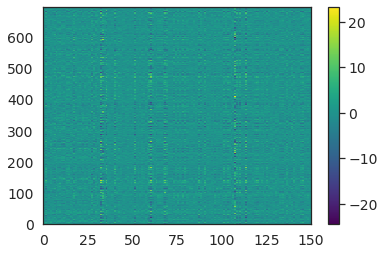

In [45]:
plt.figure();
poprec = out['pop_recons']
plt.pcolormesh(poprec[:,:,0])
plt.colorbar()

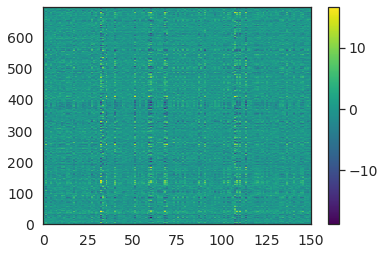

In [46]:
plt.figure();
poprec = out['pop_recons']
plt.pcolormesh(poprec[:,:,1])
plt.colorbar()

In [16]:
rec_r2 = np.mean(out['voxel_recon_r2'], axis=0)
rec_cc = np.mean(out['voxel_recon_corrcoef'], axis=0)
rec_ang = np.mean(out['voxel_recon_angle'], axis=0)
maps = [rec_cc, rec_ang]
names = ['avg reconstruction corr coef', 'avg reconstruction angle']
mins = [np.min(maps[ii]) for ii in range(len(maps))]
maxes = [np.max(maps[ii]) for ii in range(len(maps))]
cmaps = ['PuBu' for ii in range(len(maps))]
plot_utils.plot_maps_pycortex(maps, names, subject, out, fitting_type, port=33333, roi_def=roi_def, \
                       mins=mins, maxes=maxes, cmaps=cmaps)

Data is in 3d volume space
navigate browser to: 127.0.0.1:33333
Started server on port 33333


Text(0, 0.5, 'Correlation coefficient')

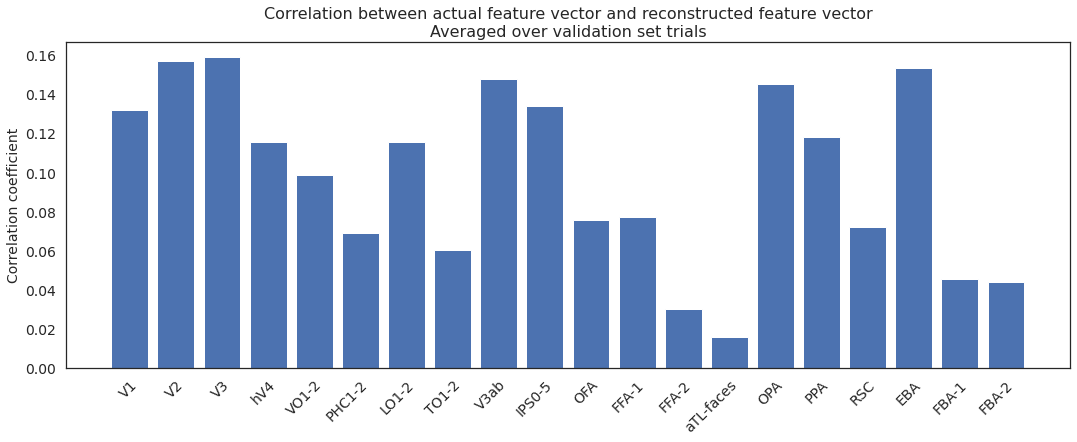

In [42]:
plt.figure(figsize=(18,6));
rois2plot = ~np.isin(np.arange(n_rois), skip_inds)
poprec_cc = out['pop_recon_corrcoef']
plt.bar(np.arange(sum(rois2plot)),np.mean(poprec_cc[:,rois2plot], axis=0))
plt.xticks(np.arange(0, sum(rois2plot)),labels=np.array(roi_names)[rois2plot], rotation=45,ha='right',rotation_mode='anchor');
plt.title('Correlation between actual feature vector and reconstructed feature vector\nAveraged over validation set trials');
plt.ylabel('Correlation coefficient')

Text(0, 0.5, 'Angle')

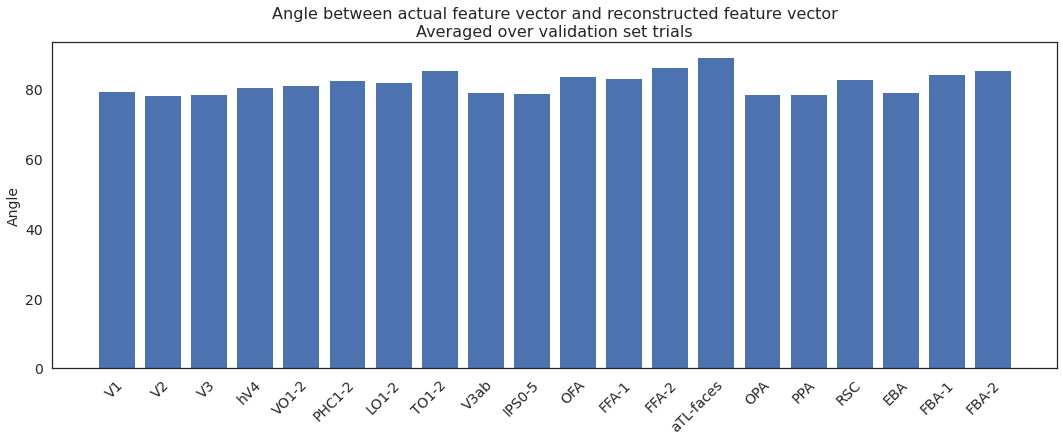

In [43]:
plt.figure(figsize=(18,6));
rois2plot = ~np.isin(np.arange(n_rois), skip_inds)
poprec_angle = out['pop_recon_angle']
plt.bar(np.arange(sum(rois2plot)),np.mean(poprec_angle[:,rois2plot], axis=0))
plt.xticks(np.arange(0, sum(rois2plot)),labels=np.array(roi_names)[rois2plot], rotation=45,ha='right',rotation_mode='anchor');
plt.title('Angle between actual feature vector and reconstructed feature vector\nAveraged over validation set trials');
plt.ylabel('Angle')

In [47]:
from utils import nsd_utils
from model_fitting import initialize_fitting
voxel_mask, voxel_index, voxel_roi, voxel_ncsnr, brain_nii_shape = roi_utils.get_voxel_roi_info(subject, volume_space, include_all=True, include_body=True)
up_to_sess = 10
sessions = np.arange(0,up_to_sess)
zscore_betas_within_sess = True
# get all data and corresponding images, in two splits. always fixed set that gets left out
trn_stim_data, trn_voxel_data, val_stim_data, val_voxel_data, \
        image_order, image_order_trn, image_order_val = nsd_utils.get_data_splits(subject, \
                                  sessions=sessions, image_inds_only = True, \
                                  voxel_mask=voxel_mask, volume_space=True, \
                                  zscore_betas_within_sess=zscore_betas_within_sess)



Volume space: ROI defs are located at: /lab_data/tarrlab/common/datasets/NSD/nsddata/ppdata/subj01/func1pt8mm/roi

3794 voxels of overlap between kastner and prf definitions, using prf defs
unique values in retino labels:
[-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25.]
unique values in face labels:
[-1.  0.  1.  2.  3.  5.]
unique values in place labels:
[-1.  0.  1.  2.  3.]
unique values in body labels:
[-1.  0.  1.  2.  3.]
1987 voxels are defined (differently) in both retinotopic areas and category areas
0 voxels are defined (differently) in both face areas and place areas
490 voxels are defined (differently) in both face areas and body areas
158 voxels are defined (differently) in both place areas and body areas
Including all voxels that are defined within nsdgeneral mask, in addition to roi labels.

19738 voxels are defined across all areas, and will be used for analysis

Loading numerical label/name mappings for all

In [48]:
trn_stim_data = image_order_trn
val_stim_data = image_order_val
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range) 


most extreme RF positions:
[-0.55 -0.55  0.04]
[0.55       0.55       0.40000001]


In [63]:
device = initialize_fitting.init_cuda()
_feature_extractor = sketch_token_feature_extractor(subject=subject, device=device, zscore_in_groups = True)



#device: 1
device#: 0
device name: GeForce RTX 2080 Ti

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32
groups for z-scoring: 
[0.]


In [66]:
_feature_extractor.init_for_fitting(image_size=(224,224), models=models, dtype=np.float32)

Initializing for fitting
Clearing features from memory


In [67]:
best_params = out['best_params']
prf_models = models
voxel_data = val_voxel_data
images = val_stim_data
zscore=True
debug=True
dtype=np.float32

In [68]:
params = best_params
device = _feature_extractor.device

n_trials, n_voxels = len(images), len(params[0])
n_prfs = prf_models.shape[0]
# n_features = params[1].shape[1]
n_features = _feature_extractor.max_features
n_features_max = n_features
n_voxels = np.shape(voxel_data)[1]

best_models, weights, bias, features_mt, features_st, best_model_inds = params

if zscore:
    if hasattr(_feature_extractor, 'zgroup_labels') and \
                    _feature_extractor.zgroup_labels is not None:
        zscore_in_groups = True
        zgroup_labels = _feature_extractor.zgroup_labels
        print('will z-score columns in groups')
    else:
        zscore_in_groups = False
        print('will z-score each column')
else:
    print('will not z-score')

pred_models = np.full(fill_value=0, shape=(n_trials, n_features_max, n_prfs), dtype=dtype)
feature_inds_defined_each_prf = np.full(fill_value=0, shape=(n_features_max, n_prfs), dtype=bool)

print('Preallocating arrays')
voxel_recons = np.zeros((n_trials, n_features, n_voxels),dtype=dtype)

recon_r2 = np.zeros((n_trials, n_voxels))
recon_angle = np.zeros((n_trials, n_voxels))
recon_corrcoef = np.zeros((n_trials, n_voxels))

will z-score columns in groups
Preallocating arrays


In [254]:
from utils import numpy_utils
#     start_time = time.time()    
#     with torch.no_grad(): # make sure local gradients are off to save memory

        # First gather texture features for all pRFs.

_feature_extractor.clear_big_features()

mm = 0
#         for mm in range(n_prfs):
#             if mm>1 and debug:
#                 break
#             print('Getting features for prf %d: [x,y,sigma] is [%.2f %.2f %.4f]'%(mm, \
#                                   prf_models[mm,0],  prf_models[mm,1],  prf_models[mm,2] ))
# all_feat_concat is size [ntrials x nfeatures]
# nfeatures may be less than n_features_max, because n_features_max is the 
# largest number possible for any pRF.
# feature_inds_defined is length max_features, and tells which of the features in 
# max_features are includes in features.
all_feat_concat, feature_inds_defined = \
        _feature_extractor(images, prf_models[mm,:], mm, fitting_mode=False)

all_feat_concat = torch_utils.get_value(all_feat_concat)

Clearing features from memory
Loading pre-computed features from /user_data/mmhender/features/sketch_tokens/S1_features_each_prf.h5py
Took 2.48016 seconds to load file
Size of features array for this image set is:
(697, 150, 1)
Final size of feature matrix is:
(697, 150)


In [258]:
if zscore:
    if zscore_in_groups:
        all_feat_concat = numpy_utils.zscore_in_groups(all_feat_concat, zgroup_labels)
    else:
        all_feat_concat = scipy.stats.zscore(all_feat_concat, axis=0)
    # if any entries in std are zero or nan, this gives bad result - fix these now.
    # these bad entries will also be zero in weights, so doesn't matter. 
    # just want to avoid nans.
    all_feat_concat[np.isnan(all_feat_concat)] = 0.0 
    all_feat_concat[np.isinf(all_feat_concat)] = 0.0 


pred_models[:,feature_inds_defined,mm] = all_feat_concat
feature_inds_defined_each_prf[:,mm] = feature_inds_defined        
if mm>0:
    # this population approach won't work if the features are not same across prfs.
    assert(np.all(feature_inds_defined ==feature_inds_defined_each_prf[:,0]))

sys.stdout.flush()
       

In [252]:
np.min(all_feat_concat)

-1.0682803392410278

In [259]:
from utils import stats_utils

_feature_extractor.clear_big_features()

vv = 9656
# for vv in range(n_voxels):

#     if vv>1 and debug:
#         break
print('processing voxel %d of %d'%(vv, n_voxels))
# weights is [voxels x features]
W = weights[vv:vv+1,:,0]
feature_inds = feature_inds_defined_each_prf[:,0]
W = W[:,feature_inds]
# validation voxel data is [trials x voxels]
V = voxel_data[:,vv:vv+1]

# reconstruction is [features x trials]
# W_centered = W - np.tile(np.mean(W, axis=1, keepdims=True), [1, n_features])
# recon = np.linalg.pinv(W_centered) @ V.T
recon = np.linalg.pinv(W) @ V.T
# [trials x features]
recon = recon.T
# recon_wcent = recon

voxel_recons[:,:,vv] = recon

# "ground truth" feature for each trial
feature_vector = pred_models[:,feature_inds,0]

# feature_vector = pred_models[:,feature_inds,best_model_inds[vv,0]]
feature_vector_centered = feature_vector - np.tile(np.mean(feature_vector, axis=1, keepdims=True),\
                                                   [1,n_features])
recon_centered = recon - np.tile(np.mean(recon, axis=1, keepdims=True),\
                                                   [1, n_features])

# computing r2 for each single-trial recon (i.e. over the features dim)
# so need to transpose for this fn
# recon_r2[:,vv] = stats_utils.get_r2(feature_vector.T, recon.T)
# recon_corrcoef[:,vv] = stats_utils.get_corrcoef(feature_vector.T, recon.T)
recon_r2[:,vv] = stats_utils.get_r2(feature_vector_centered.T, recon_centered.T)
recon_corrcoef[:,vv] = stats_utils.get_corrcoef(feature_vector_centered.T, recon_centered.T)


dp = np.sum(feature_vector_centered*recon_centered, axis=1)
cosangle = dp / (np.sqrt(np.sum(feature_vector_centered**2, axis=1)) * \
                 np.sqrt(np.sum(recon_centered**2, axis=1)))
recon_angle[:,vv] = np.arccos(cosangle) * 180/np.pi

sys.stdout.flush()

# recon_r2 = np.nan_to_num(recon_r2)
# recon_corrcoef = np.nan_to_num(recon_corrcoef)
# recon_angle = np.nan_to_num(recon_angle)
       

Clearing features from memory
processing voxel 9656 of 19738


In [105]:
x = np.random.normal(0,1,(1,20))
y = x+np.random.normal(0,1,(1,20))*0.1
y_shift = y+2

print(np.dot(x,y.T)[0][0])
print(np.dot(x,y_shift.T)[0][0])

print(np.dot(x - np.mean(x),(y-np.mean(y)).T)[0][0])
print(np.dot(x - np.mean(x),(y_shift-np.mean(y_shift)).T)[0][0])

print(np.corrcoef(x,y))
print(np.corrcoef(x, (y_shift)))

26.356311231069416
22.243012854200085
26.062448162942665
26.062448162942662
[[1.         0.99650681]
 [0.99650681 1.        ]]
[[1.         0.99650681]
 [0.99650681 1.        ]]


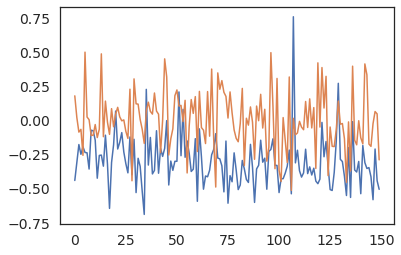

In [131]:
ti = np.argmax(recon_corrcoef[:,vv])
plt.figure();
plt.plot(feature_vector[ti,:])
plt.plot(recon[ti,:])

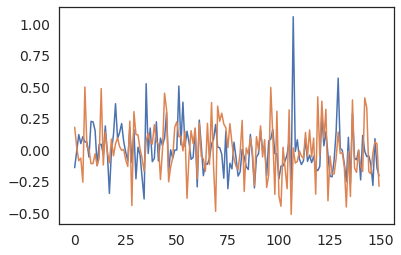

In [132]:
ti = np.argmax(recon_corrcoef[:,vv])
plt.figure();
plt.plot(feature_vector_centered[ti,:])
plt.plot(recon_centered[ti,:])

In [92]:
np.corrcoef(feature_vector[ti,:], recon[ti,:])

array([[1.        , 0.31043442],
       [0.31043442, 1.        ]])

In [120]:
recon_corrcoef[ti,vv]

0.3104344308376312

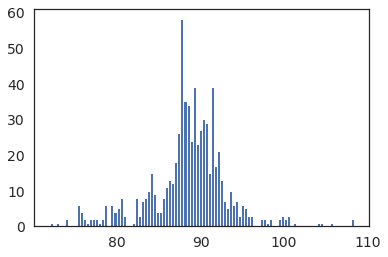

In [250]:
plt.figure();
plt.hist(recon_angle[:,vv],100);

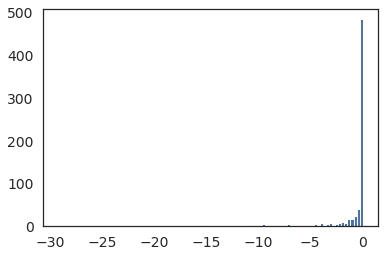

In [130]:
plt.figure();
plt.hist(recon_r2[:,vv],100);

In [75]:
recon_angle[0:10,vv]

array([94.24517306, 84.56766277, 80.99967725, 90.59167533, 80.59983471,
       88.06212945, 90.59167533, 94.80716835, 77.82069269, 78.25410525])

In [78]:
out['voxel_recon_angle'][0:10,vv]

array([94.24517306, 84.56766277, 80.99967725, 90.59167533, 80.59983471,
       88.06212945, 90.59167533, 94.80716835, 77.82069269, 78.25410525])

In [81]:
out['voxel_recons'][10,0:10,vv]

array([-0.13316987, -0.03815233,  0.02586163,  0.01387625,  0.12786202,
       -0.324898  , -0.04024822, -0.02864052,  0.0404941 ,  0.03921633],
      dtype=float32)

In [82]:
recon[10,0:10]

array([-0.13316988, -0.03815233,  0.02586163,  0.01387625,  0.12786203,
       -0.324898  , -0.04024822, -0.02864052,  0.0404941 ,  0.03921633])

In [260]:
# loading pre-computed linear discriminant analysis features
sketch_token_feat_path = default_paths.sketch_token_feat_path

lda_discrim_type = 'animacy'
features_file = os.path.join(sketch_token_feat_path, 'LDA', \
                                                  'S%d_LDA_%s.npy'%(subject, lda_discrim_type))

lda_result = np.load(features_file, allow_pickle=True).item()

scores_each_prf = lda_result['scores']

In [278]:
'sketch_tokens' in _feature_extractor.features_file

False

In [261]:
animacy_labels = lda_result['labels_actual'][mm][images]

In [175]:
animacy_labels.shape

(697,)

In [315]:
mm = 591
lda_wts = lda_result['wts'][mm]
lda_pre_mean = lda_result['pre_mean'][mm]
lda_wts.shape
lda_pre_mean.shape

(150,)

In [316]:
sc  =lda_result['scores'][mm][images,0]

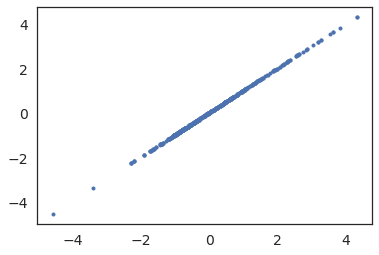

In [319]:
plt.figure();
plt.plot(sc, features_proj,'.')

In [320]:
sc[0:10]

array([-0.6852537 , -0.38513589, -1.89699107,  0.50839291,  1.57641307,
       -0.18776243,  0.50839291, -0.30644687,  0.74884816, -0.96511023])

In [321]:
features_proj[0:10]

array([[-0.64461066],
       [-0.34521062],
       [-1.85344984],
       [ 0.54618111],
       [ 1.61164691],
       [-0.14830922],
       [ 0.54618111],
       [-0.26670976],
       [ 0.78606142],
       [-0.92379773]])

In [318]:
# Projecting both the "real" feature vector and the "reconstruction" onto the animacy axis
features_submean = feature_vector - np.tile(lda_pre_mean[np.newaxis,:], [n_trials,1])
features_proj = features_submean @ lda_wts

# recon_submean = recon_centered - np.tile(lda_pre_mean[np.newaxis,:], [n_trials,1])
recon_submean = recon - np.tile(lda_pre_mean[np.newaxis,:], [n_trials,1])
recon_proj = recon_submean @ lda_wts

In [266]:
recon_proj[0:10]

array([[-1.04120524],
       [-0.09020763],
       [-0.70906576],
       [-0.35989346],
       [ 0.31999879],
       [ 0.11560526],
       [-0.72042094],
       [-0.66648371],
       [ 0.03469948],
       [-0.69913   ]])

In [268]:
recon_proj[0:10]

array([[-1.00474892],
       [-0.09846797],
       [-0.6882269 ],
       [-0.35547295],
       [ 0.29245021],
       [ 0.09766743],
       [-0.69904814],
       [-0.64764709],
       [ 0.02056591],
       [-0.67875832]])

Text(0.5, 1.0, 'voxel 9656, V1')

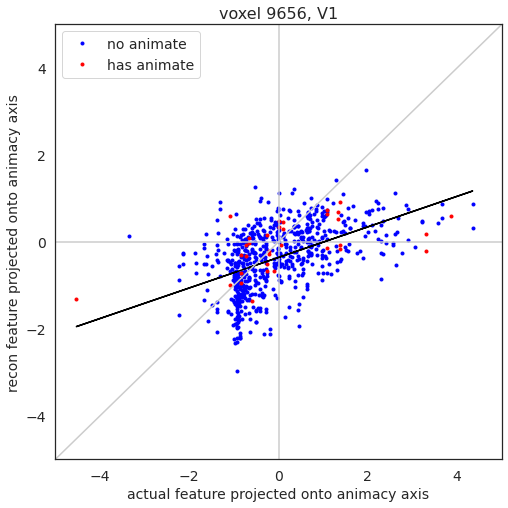

In [283]:
lim=5
plt.figure(figsize=(8,8));
lh1 = plt.plot(features_proj[animacy_labels==0,0], recon_proj[animacy_labels==0,0], '.',color='b')
lh2 = plt.plot(features_proj[animacy_labels==1,0], recon_proj[animacy_labels==1,0], '.',color='r')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.axvline(0, color=[0.8, 0.8, 0.8])
plt.xlabel('actual feature projected onto animacy axis')
plt.ylabel('recon feature projected onto animacy axis')
plt.xlim([-lim, lim]);
plt.ylim([-lim, lim]);
plt.plot(a, b_pred, color='k')
plt.plot([plt.gca().get_xlim()[0], plt.gca().get_xlim()[1]],\
         [plt.gca().get_ylim()[0], plt.gca().get_ylim()[1]], color=[0.8, 0.8, 0.8])
# plt.axis('square');
plt.legend([lh1[0], lh2[0]], ['no animate','has animate'])
plt.title('voxel %d, %s'%(vv, np.array(ret_names)[int(retlabs[vind])]))

In [295]:
a = np.concatenate([features_proj, np.ones(np.shape(features_proj))], axis=1)
b = recon_proj
x = np.linalg.pinv(a) @ b

slope = x[0]
inter = x[1]

b_pred = a[:,0]*slope + inter
ssr = np.sum((b_pred-b[:,0])**2)
sst = np.sum((b[:,0] - np.mean(b[:,0]))**2)
r2 = 1-ssr/sst

In [322]:
_feature_extractor.subject

1

In [299]:
b.shape

(697, 1)

In [292]:
np.mean(b)

-0.37384031292538583

In [305]:
ssr

288.0144808633122

In [306]:
sst

390.0661377088054

In [303]:
r2

0.26162654734638213

In [304]:
np.linalg.lstsq(a,b)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


(array([[ 0.35129183],
        [-0.35777976]]),
 array([288.01448086]),
 2,
 array([28.90908254, 26.26177433]))

In [61]:
import numpy as np
import sys, os
import torch
import time
import h5py
import pandas as pd
import torch.nn as nn
from sklearn import decomposition

from utils import prf_utils, torch_utils, texture_utils, default_paths
sketch_token_feat_path = default_paths.sketch_token_feat_path

class sketch_token_feature_extractor(nn.Module):
    
    def __init__(self, subject, device,\
                 use_pca_feats = False, min_pct_var = 99, max_pc_to_retain = 100, \
                 use_lda_feats = False, lda_discrim_type = None, zscore_in_groups = False):
        
        super(sketch_token_feature_extractor, self).__init__()
        
        self.subject = subject
        
        self.use_pca_feats = use_pca_feats
        self.use_lda_feats = use_lda_feats
        self.lda_discrim_type = lda_discrim_type
        
        if self.use_pca_feats:
            self.n_features = 151
            self.use_lda_feats = False # only allow one of these to be true
            self.features_file = os.path.join(sketch_token_feat_path, 'PCA', 'S%d_PCA.npy'%(subject))     
            self.min_pct_var = min_pct_var
            self.max_pc_to_retain = np.min([self.n_features, max_pc_to_retain])
        elif self.use_lda_feats:
            self.use_pca_feats = False
            self.min_pct_var = None
            self.max_pc_to_retain = None  
            if self.lda_discrim_type=='all_supcat':
                self.n_features = 11     
                self.features_file = os.path.join(sketch_token_feat_path, 'LDA', \
                                                  'S%d_LDA_all_supcat.npy'%(subject))  
            elif self.lda_discrim_type=='animacy' or self.lda_discrim_type=='indoor_outdoor' or \
                    self.lda_discrim_type=='animal' or self.lda_discrim_type=='vehicle' or \
                    self.lda_discrim_type=='food' or self.lda_discrim_type=='person':
                self.n_features = 1 
                self.features_file = os.path.join(sketch_token_feat_path, 'LDA', \
                                                  'S%d_LDA_%s.npy'%(subject, self.lda_discrim_type))     
            else:
                print(lda_discrim_type)
                raise ValueError('--lda_discrim_type was not recognized')
        else:
            self.n_features = 150 # 151
            self.features_file = os.path.join(sketch_token_feat_path, 'S%d_features_each_prf.h5py'%(subject))
            self.min_pct_var = None
            self.max_pc_to_retain = None  
            if zscore_in_groups:
                self.zgroup_labels = np.concatenate([np.zeros(shape=(1,150)), np.ones(shape=(1,1))], axis=1)
                self.zgroup_labels = self.zgroup_labels[0,0:self.n_features]
                print('groups for z-scoring: ')
                print(np.unique(self.zgroup_labels))
            else:
                self.zgroup_labels = None
            
        if not os.path.exists(self.features_file):
            raise RuntimeError('Looking at %s for precomputed features, not found.'%self.features_file)

        self.device = device
        self.do_varpart=False # only one set of features in this model for now, not doing variance partition
        self.features_each_prf = None
        
    def init_for_fitting(self, image_size, models, dtype):

        """
        Additional initialization operations.
        """
        
        print('Initializing for fitting')

        if self.use_pca_feats:
            self.max_features = self.max_pc_to_retain        
        else:
            self.max_features = self.n_features
       
        self.clear_big_features()
        
    def get_partial_versions(self):

        if not hasattr(self, 'max_features'):
            raise RuntimeError('need to run init_for_fitting first')
           
        partial_version_names = ['full_model']
        masks = np.ones([1,self.max_features])

        return masks, partial_version_names

    def load_precomputed_features(self, image_inds):
        
        print('Loading pre-computed features from %s'%self.features_file)
        t = time.time()
           
        if self.use_pca_feats:
            
            # loading pre-computed pca features, and deciding here how many features to include in model.
            pc_result = np.load(self.features_file, allow_pickle=True).item()
            scores_each_prf = pc_result['scores']
            ev_each_prf = pc_result['ev']
            n_pcs_avail = scores_each_prf[0].shape[1]
            n_feat_each_prf = [np.where(np.cumsum(ev)>self.min_pct_var)[0][0] \
                               if np.size(np.where(np.cumsum(ev)>self.min_pct_var))>0 \
                               else n_pcs_avail for ev in ev_each_prf]
            n_feat_each_prf = [np.min([nf, self.max_pc_to_retain]) for nf in n_feat_each_prf]
            self.features_each_prf = [scores_each_prf[mm][image_inds,0:n_feat_each_prf[mm]] \
                                      for mm in range(len(scores_each_prf))]           
            print('Size of features array for first prf model with this image set is:')
            print(self.features_each_prf[0].shape)

        elif self.use_lda_feats:
            
            # loading pre-computed linear discriminant analysis features
            lda_result = np.load(self.features_file, allow_pickle=True).item()
            scores_each_prf = lda_result['scores']

            self.features_each_prf = np.moveaxis(np.array([scores_each_prf[mm][image_inds,:] \
                          for mm in range(len(scores_each_prf))]), [0,1,2], [2,0,1])
            assert(self.features_each_prf.shape[1]==self.max_features)
            print('Size of features array for this image set is:')
            print(self.features_each_prf.shape)
        
        else:
            
            # Loading raw sketch tokens features.
            with h5py.File(self.features_file, 'r') as data_set:
                values = np.copy(data_set['/features'][:,:,591:592])
                data_set.close() 
            elapsed = time.time() - t
            print('Took %.5f seconds to load file'%elapsed)

            self.features_each_prf = values[image_inds,:,:]
            # Taking out the very last column, which represents "no contour"
            self.features_each_prf = self.features_each_prf[:,0:150,:]
            
            print('Size of features array for this image set is:')
            print(self.features_each_prf.shape)
        
    def clear_big_features(self):
        
        print('Clearing features from memory')
        self.features_each_prf = None 
    
    def forward(self, image_inds, prf_params, prf_model_index, fitting_mode = True):
        
        if self.features_each_prf is None:
            self.load_precomputed_features(image_inds)
        
        if self.use_pca_feats:
            features = self.features_each_prf[prf_model_index]
        else:
            features = self.features_each_prf[:,:,prf_model_index]
        
        assert(features.shape[0]==len(image_inds))
        print('Final size of feature matrix is:')
        print(features.shape)
        
        features = torch_utils._to_torch(features, self.device)
        
        feature_inds_defined = np.zeros((self.max_features,), dtype=bool)
        feature_inds_defined[0:features.shape[1]] = 1
            
        return features, feature_inds_defined
     
    
def get_features_each_prf(features_file, models, mult_patch_by_prf=True, do_avg_pool=True, \
                          batch_size=100, aperture=1.0, debug=False, device=None):
    """
    Extract the portion of the feature maps corresponding to each prf in 'models'
    Start with loading the feature maps h5py file (generated by get_st_features.m)
    Save smaller features as an h5py file [n_images x n_features x n_prfs]
    """
    if device is None:
        device = 'cpu:0'
        
    with h5py.File(features_file, 'r') as data_set:
        ds_size = data_set['/features'].shape
    n_images = ds_size[3]
    n_features = ds_size[0]
    map_resolution = ds_size[1]
    n_prfs = models.shape[0]
    features_each_prf = np.zeros((n_images, n_features, n_prfs))
    n_batches = int(np.ceil(n_images/batch_size))

    for bb in range(n_batches):

        if debug and bb>1:
            continue

        batch_inds = np.arange(batch_size * bb, np.min([batch_size * (bb+1), n_images]))

        print('Loading features for images [%d - %d]'%(batch_inds[0], batch_inds[-1]))
        st = time.time()
        with h5py.File(features_file, 'r') as data_set:
            # Note this order is reversed from how it was saved in matlab originally.
            # The dimensions go [features x h x w x images]
            # Luckily h and w are swapped matlab to python anyway, so can just switch the first and last.
            values = np.copy(data_set['/features'][:,:,:,batch_inds])
            data_set.close()  
        fmaps_batch = np.moveaxis(values, [0,1,2,3],[3,1,2,0])

        elapsed = time.time() - st
        print('Took %.5f sec to load feature maps'%elapsed)

        maps_full_field = torch_utils._to_torch(fmaps_batch, device=device)

        for mm in range(n_prfs):

            if debug and mm>1:
                continue

            prf_params = models[mm,:]
            x,y,sigma = prf_params
            print('Getting features for pRF [x,y,sigma]:')
            print([x,y,sigma])
            n_pix = map_resolution

             # Define the RF for this "model" version
            prf = torch_utils._to_torch(prf_utils.make_gaussian_mass(x, y, sigma, n_pix, size=aperture, \
                                      dtype=np.float32)[2], device=device)
            minval = torch.min(prf)
            maxval = torch.max(prf-minval)
            prf_scaled = (prf - minval)/maxval

            if mult_patch_by_prf:         
                # This effectively restricts the spatial location, so no need to crop
                maps = maps_full_field * prf_scaled.view([1,map_resolution,map_resolution,1])
            else:
                # This is a coarser way of choosing which spatial region to look at
                # Crop the patch +/- n SD away from center
                n_pf_sd_out = 2
                bbox = texture_utils.get_bbox_from_prf(prf_params, prf.shape, n_prf_sd_out, min_pix=None, verbose=False, force_square=False)
                print('bbox to crop is:')
                print(bbox)
                maps = maps_full_field[:,bbox[0]:bbox[1], bbox[2]:bbox[3],:]

            if do_avg_pool:
                features_batch = torch.mean(maps, dim=(1,2))
            else:
                features_batch = torch.max(maps, dim=(1,2))
                
            print('model %d, min/max of features in batch: [%s, %s]'%(mm, torch.min(features_batch), torch.max(features_batch))) 

            features_each_prf[batch_inds,:,mm] = torch_utils.get_value(features_batch)
                      
    return features_each_prf